Assigment 2

Import Libraries

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Import Data

In [2]:
stocks = ["CL=F", "MSFT", "^STOXX50E", "XWD.TO", "EEM", "EUR=X"]
start_date = "2023-10-01"
end_date = "2024-09-30"   

stock_data = yf.download(stocks, start=start_date, end=end_date)['Close']


[*********************100%***********************]  6 of 6 completed


In [3]:
stock_data.head(5)

Ticker,CL=F,EEM,EUR=X,MSFT,XWD.TO,^STOXX50E
Date,,,,,,
2023-10-02 00:00:00+00:00,88.820000,37.759998,0.94650,321.799988,70.459999,4137.629883
2023-10-03 00:00:00+00:00,89.230003,37.259998,0.95413,313.390015,69.870003,4095.590088
2023-10-04 00:00:00+00:00,84.220001,37.150002,0.95490,318.959991,70.480003,4099.850098
2023-10-05 00:00:00+00:00,82.309998,37.290001,0.95174,319.359985,70.449997,4099.810059
2023-10-06 00:00:00+00:00,82.790001,37.830002,0.94817,327.260010,70.989998,4144.430176


Data Preparation

In [4]:
print(stock_data.isna().sum())

Ticker
CL=F         10
EEM          10
EUR=X         0
MSFT         10
XWD.TO       10
^STOXX50E    10
dtype: int64


In [5]:
def fill_na_with_mean(df):
    return df.fillna((df.shift(1) + df.shift(-1)) / 2)
new_stock_data = stock_data.apply(fill_na_with_mean)

In [6]:
new_stock_data.head(5)

Ticker,CL=F,EEM,EUR=X,MSFT,XWD.TO,^STOXX50E
Date,,,,,,
2023-10-02 00:00:00+00:00,88.820000,37.759998,0.94650,321.799988,70.459999,4137.629883
2023-10-03 00:00:00+00:00,89.230003,37.259998,0.95413,313.390015,69.870003,4095.590088
2023-10-04 00:00:00+00:00,84.220001,37.150002,0.95490,318.959991,70.480003,4099.850098
2023-10-05 00:00:00+00:00,82.309998,37.290001,0.95174,319.359985,70.449997,4099.810059
2023-10-06 00:00:00+00:00,82.790001,37.830002,0.94817,327.260010,70.989998,4144.430176


Stock Indicators

In [7]:
def calculate_macd(df, short_window=12, long_window=26, signal_window=9):
    short_ema = df.ewm(span=short_window, adjust=False).mean()
    long_ema = df.ewm(span=long_window, adjust=False).mean()

    macd = short_ema - long_ema

    signal = macd.ewm(span=signal_window, adjust=False).mean()
    histogram = macd - signal

    return macd, signal, histogram


def calculate_rsi(df, window=14):
    diff = df.diff(1)

    up_chg = pd.Series(0, index=diff.index) 
    down_chg = pd.Series(0, index=diff.index)

    up_chg[diff > 0] = diff[diff > 0]
    down_chg[diff < 0] = -diff[diff < 0]  
    up_chg_avg = up_chg.ewm(com=window - 1, min_periods=window).mean()
    down_chg_avg = down_chg.ewm(com=window - 1, min_periods=window).mean()

    rs = up_chg_avg / down_chg_avg
    rsi = 100 - (100 / (1 + rs))

    return rsi

def calculate_bollinger_bands(df, window=20):
    sma = df.rolling(window=window).mean()
    std_dev = df.rolling(window=window).std()

    upper_band = sma + (std_dev * 2)
    lower_band = sma - (std_dev * 2)
    
    return sma, upper_band, lower_band


In [8]:
def simulate_trading(df, signal_function, **kwargs):
    total_profit = 0
    position = 0  
    buy_price = 0

    signals = signal_function(df, **kwargs)

    for i in range(1, len(df)):
        price_today = df.iloc[i]

        # Buy signal
        if position == 0 and signals[i] == 1:  # Buy signal
            buy_price = price_today
            position = 1
        # Sell signal
        elif position == 1 and signals[i] == -1:  # Sell signal
            total_profit += price_today - buy_price
            position = 0
    
    return total_profit

In [9]:
def macd_signals(df):
    macd, signal, histogram = calculate_macd(df) 
    signals = pd.Series(index=df.index, data=0) 

    buy_signals = (macd[1:] > signal[1:])
    sell_signals = (macd[1:] < signal[1:])

    signals[1:] = 1 * buy_signals.astype(int) - 1 * sell_signals.astype(int)  # 1 für Kauf, -1 für Verkauf
    return signals

def rsi_signals(df, threshold_buy=30, threshold_sell=70):
    rsi = calculate_rsi(df)
    signals = pd.Series(index=df.index, data=0)
    signals[rsi < threshold_buy] = 1  # Buy signal
    signals[rsi > threshold_sell] = -1  # Sell signal
    return signals

def bollinger_band_signals(df):
    _, upper_band, lower_band = calculate_bollinger_bands(df)
    signals = pd.Series(index=df.index, data=0)
    signals[df < lower_band] = 1  # Buy signal
    signals[df > upper_band] = -1  # Sell signal
    return signals


In [10]:
def evaluate_indicators(df):
    results = {}
    indicators = {
        'MACD': macd_signals,
        'RSI': rsi_signals,
        'Bollinger Bands': bollinger_band_signals
    }
    
    for symbol in df.columns:
        results[symbol] = {}
        for indicator_name, signal_function in indicators.items():
            profit = simulate_trading(df[symbol], signal_function)
            results[symbol][indicator_name] = profit
    
    return results

In [11]:
indicator_performance = evaluate_indicators(new_stock_data)

# Print results
print("Profit/Loss Results by Indicator:")
for symbol, profits in indicator_performance.items():
    print(f"\n{symbol}:")
    for indicator, profit in profits.items():
        print(f"  {indicator}: Total Profit: {profit:.2f}")

Profit/Loss Results by Indicator:

CL=F:
  MACD: Total Profit: -25.03
  RSI: Total Profit: 0.00
  Bollinger Bands: Total Profit: -0.01

EEM:
  MACD: Total Profit: 1.62
  RSI: Total Profit: 0.00
  Bollinger Bands: Total Profit: 9.62

EUR=X:
  MACD: Total Profit: -0.03
  RSI: Total Profit: 0.02
  Bollinger Bands: Total Profit: 0.03

MSFT:
  MACD: Total Profit: 70.53
  RSI: Total Profit: 0.00
  Bollinger Bands: Total Profit: 15.69

XWD.TO:
  MACD: Total Profit: 6.79
  RSI: Total Profit: 0.00
  Bollinger Bands: Total Profit: 6.44

^STOXX50E:
  MACD: Total Profit: 666.86
  RSI: Total Profit: 0.00
  Bollinger Bands: Total Profit: 295.00


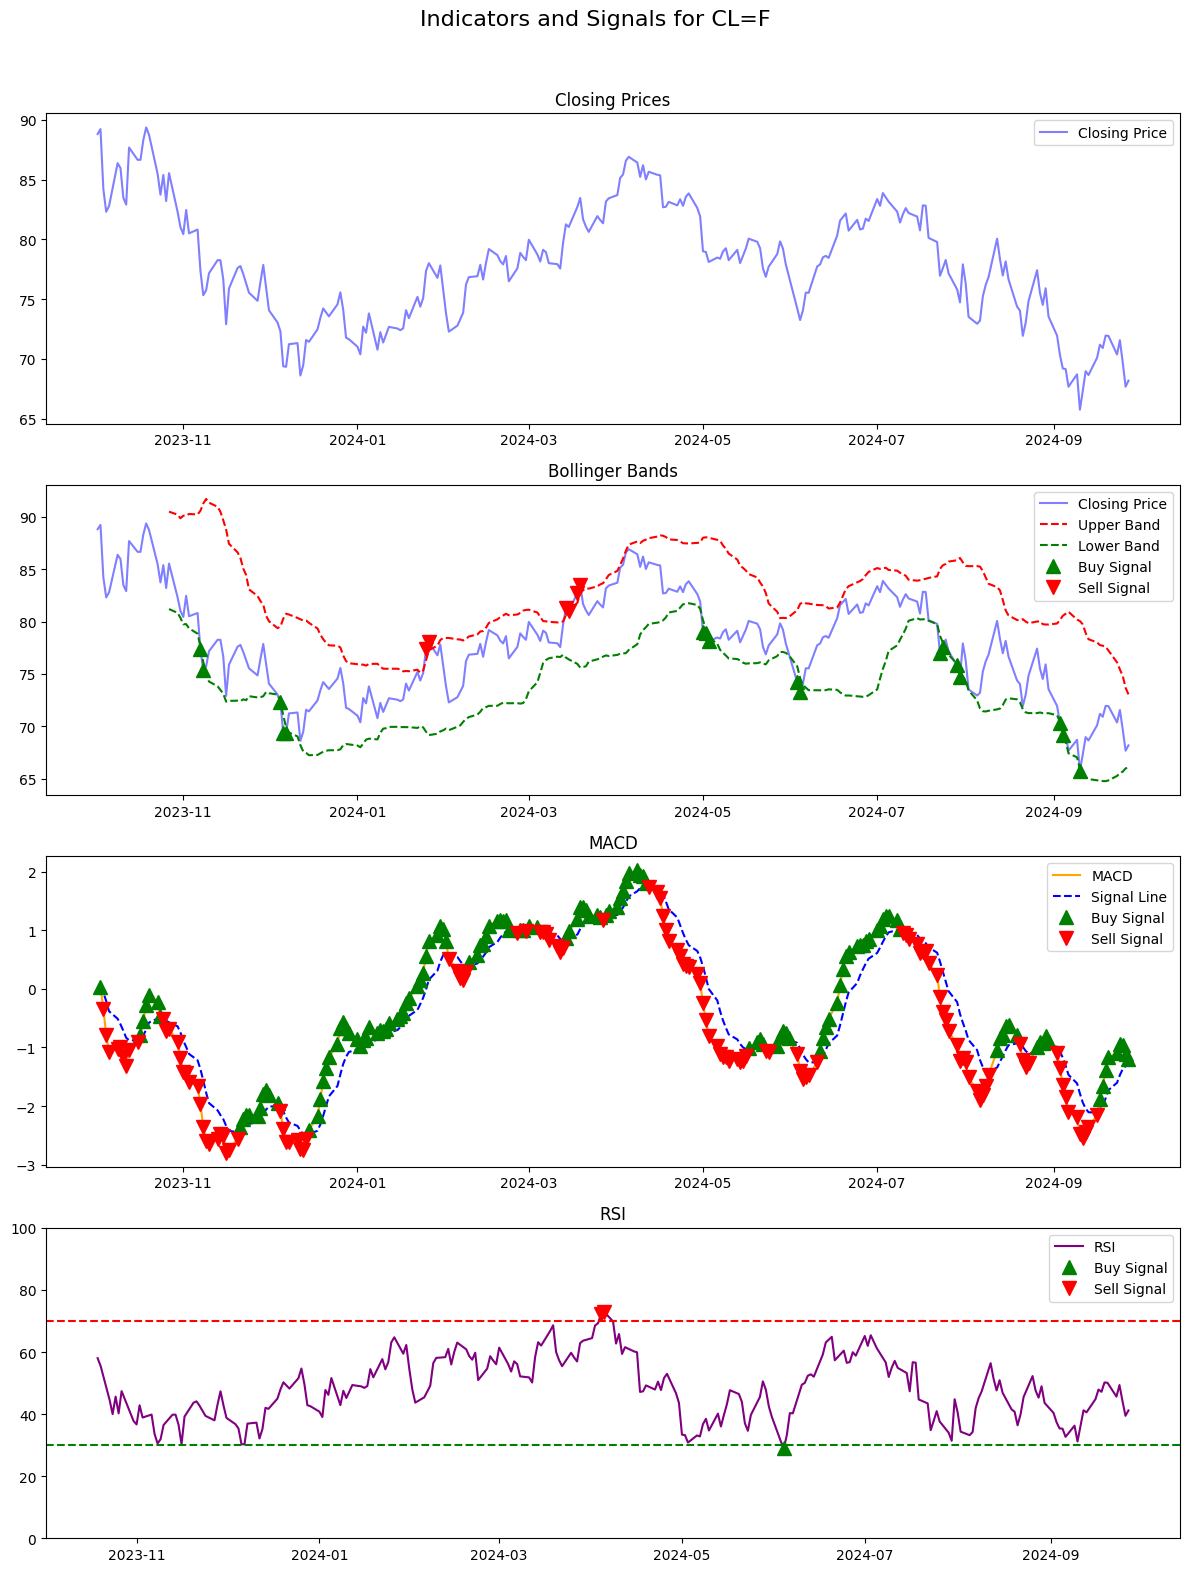

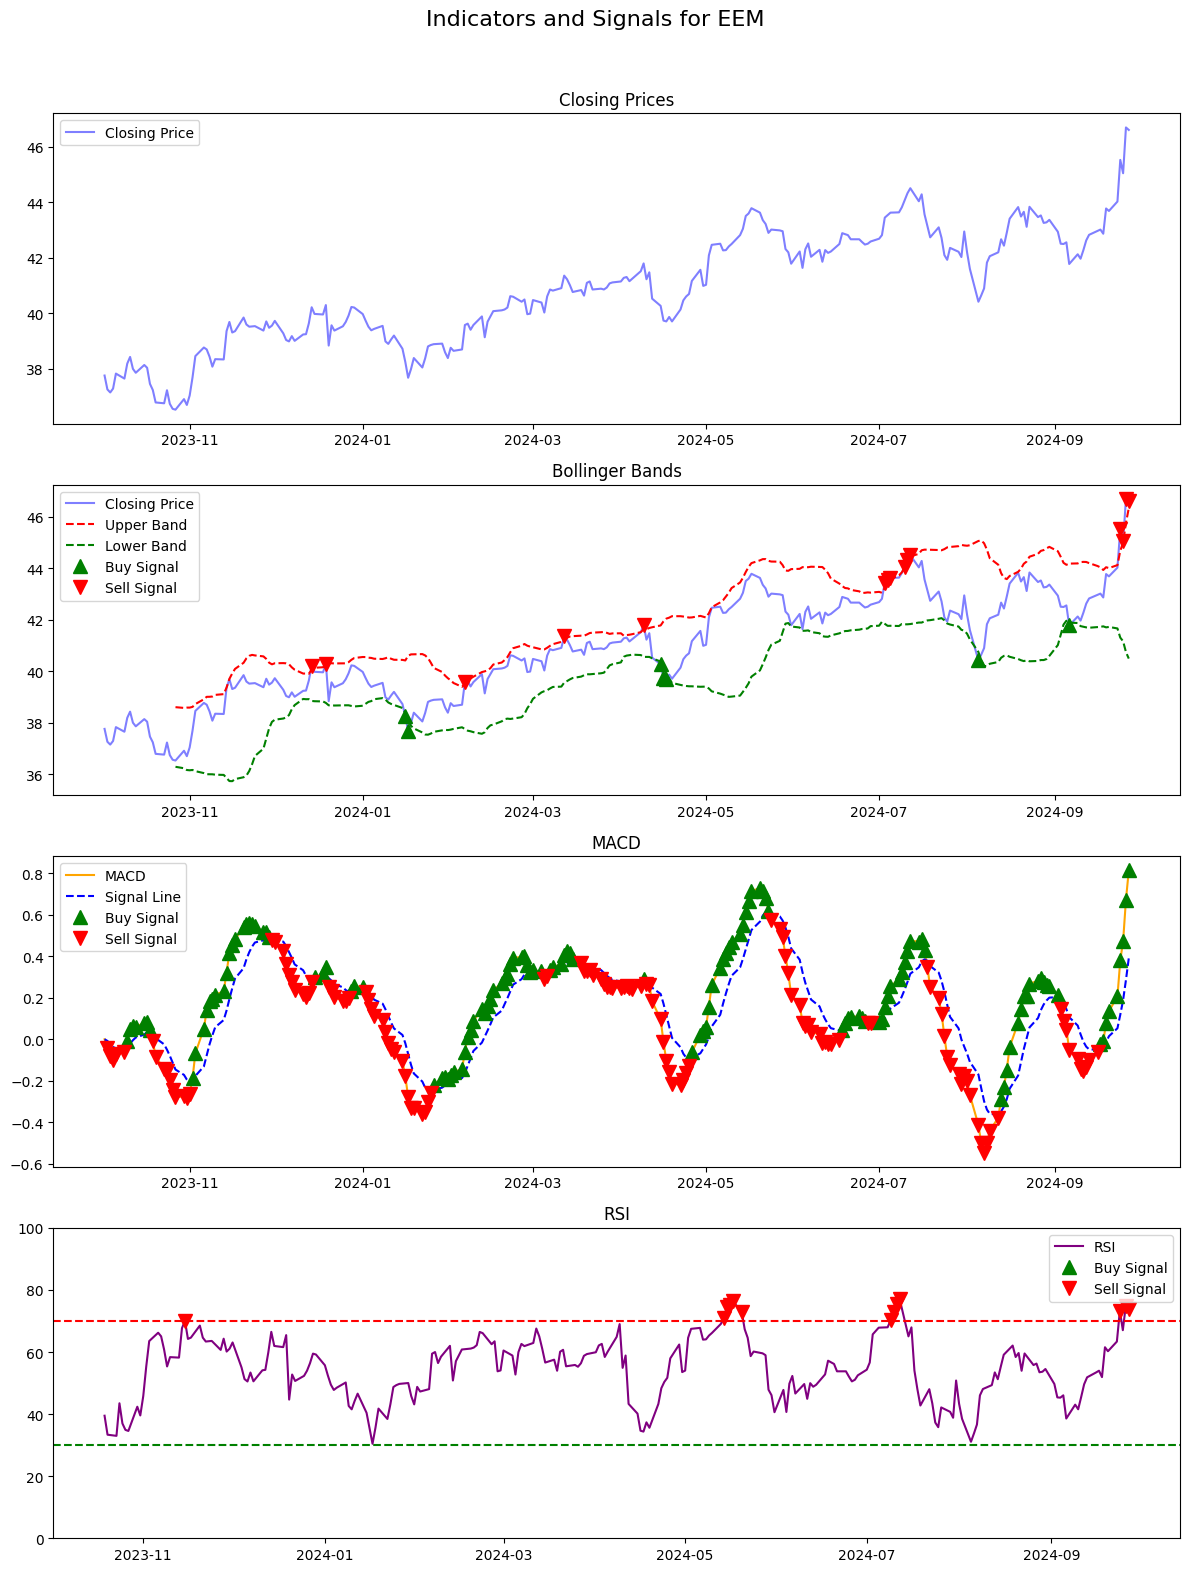

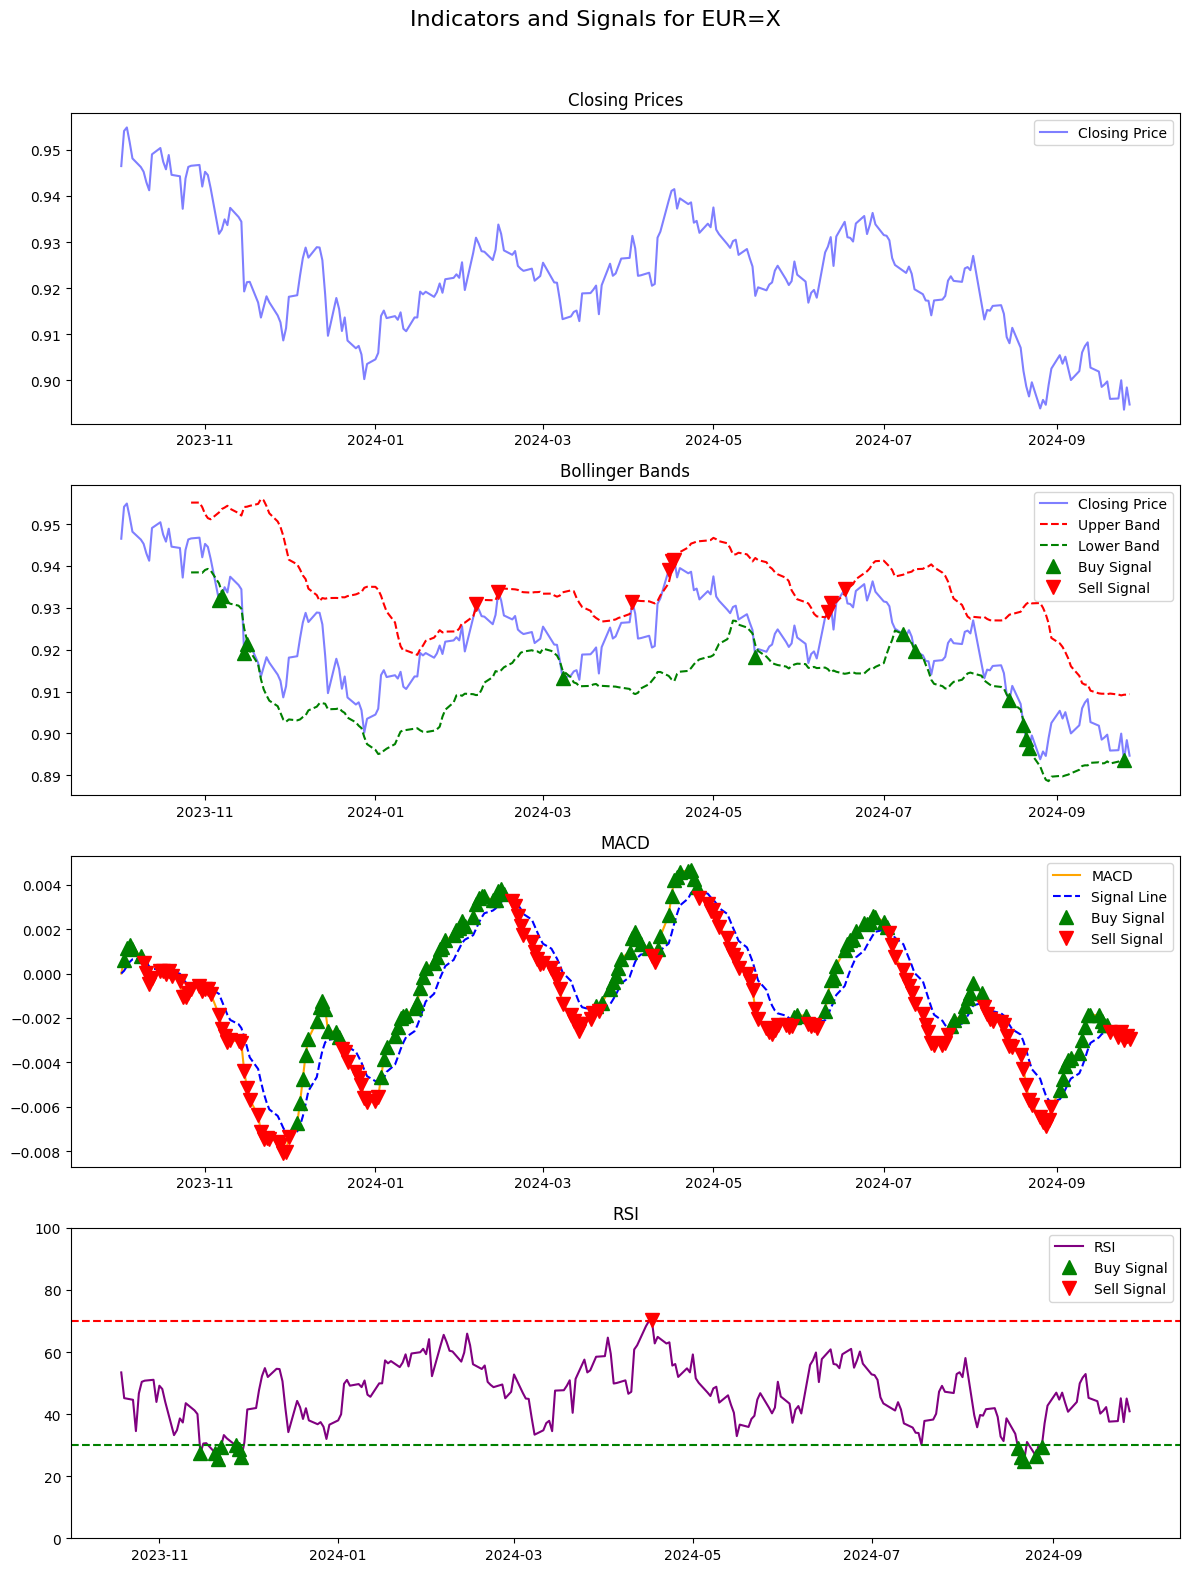

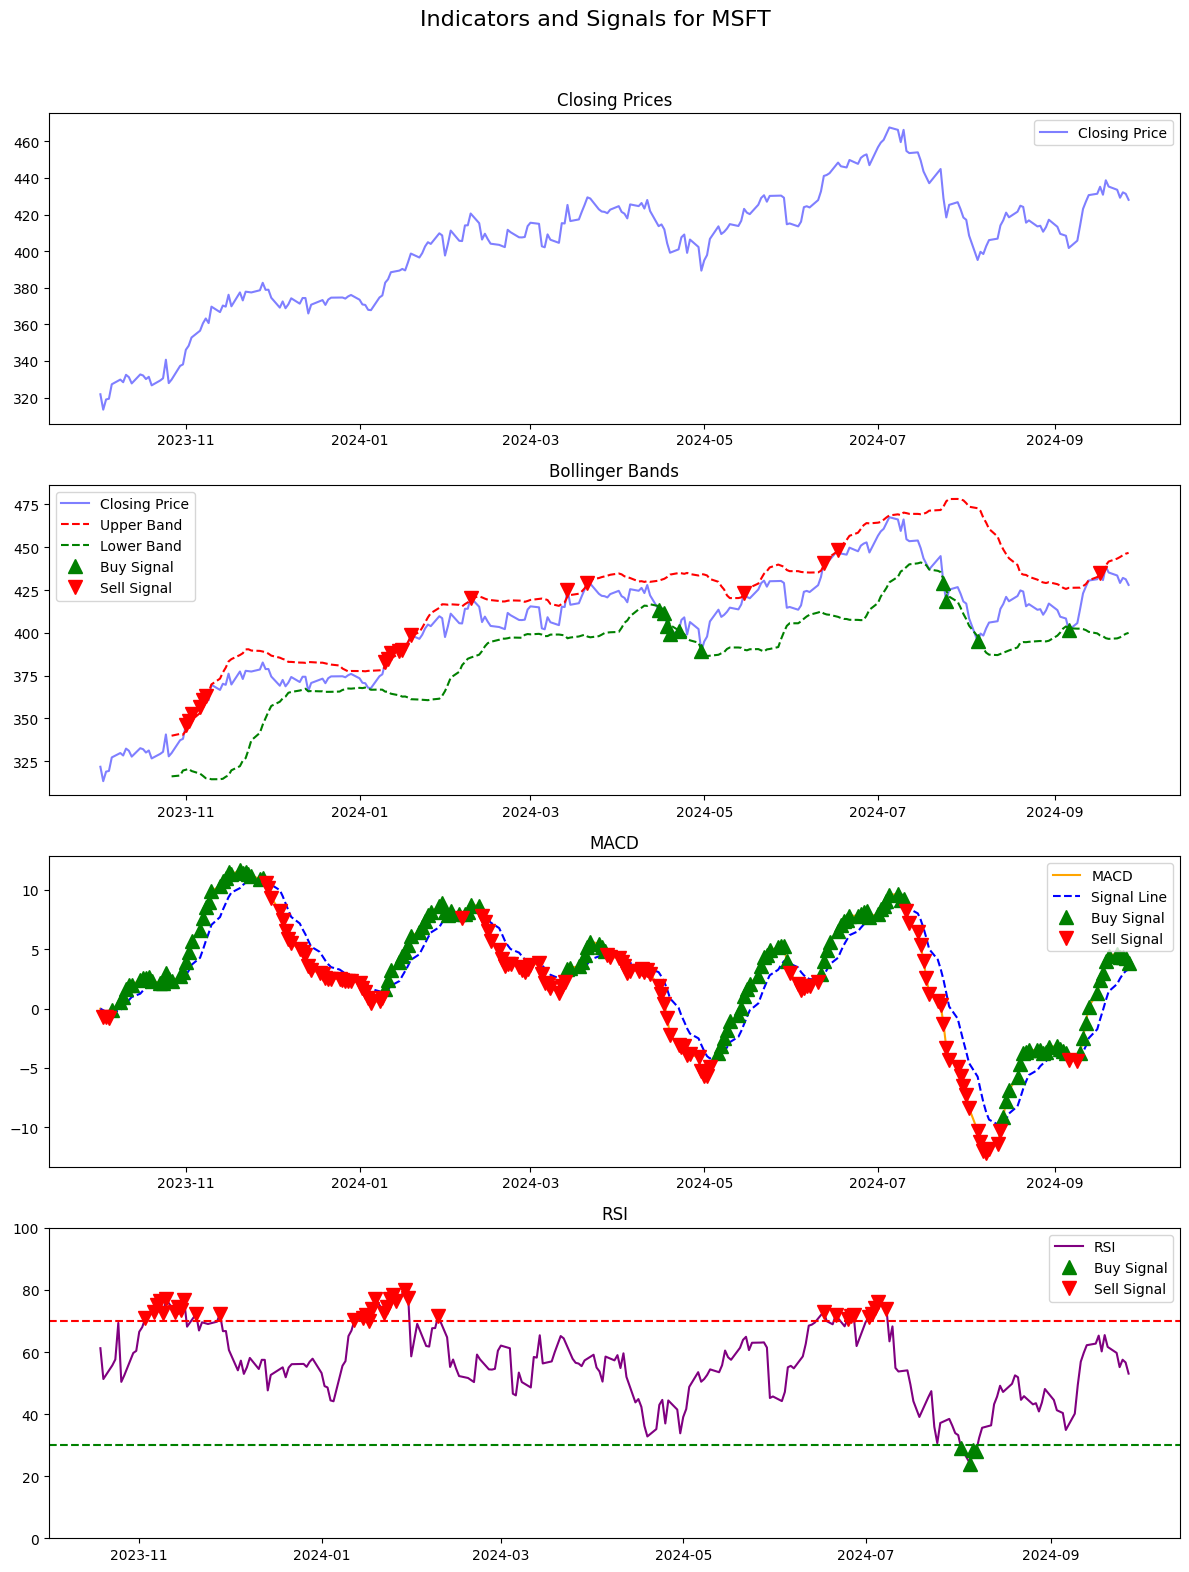

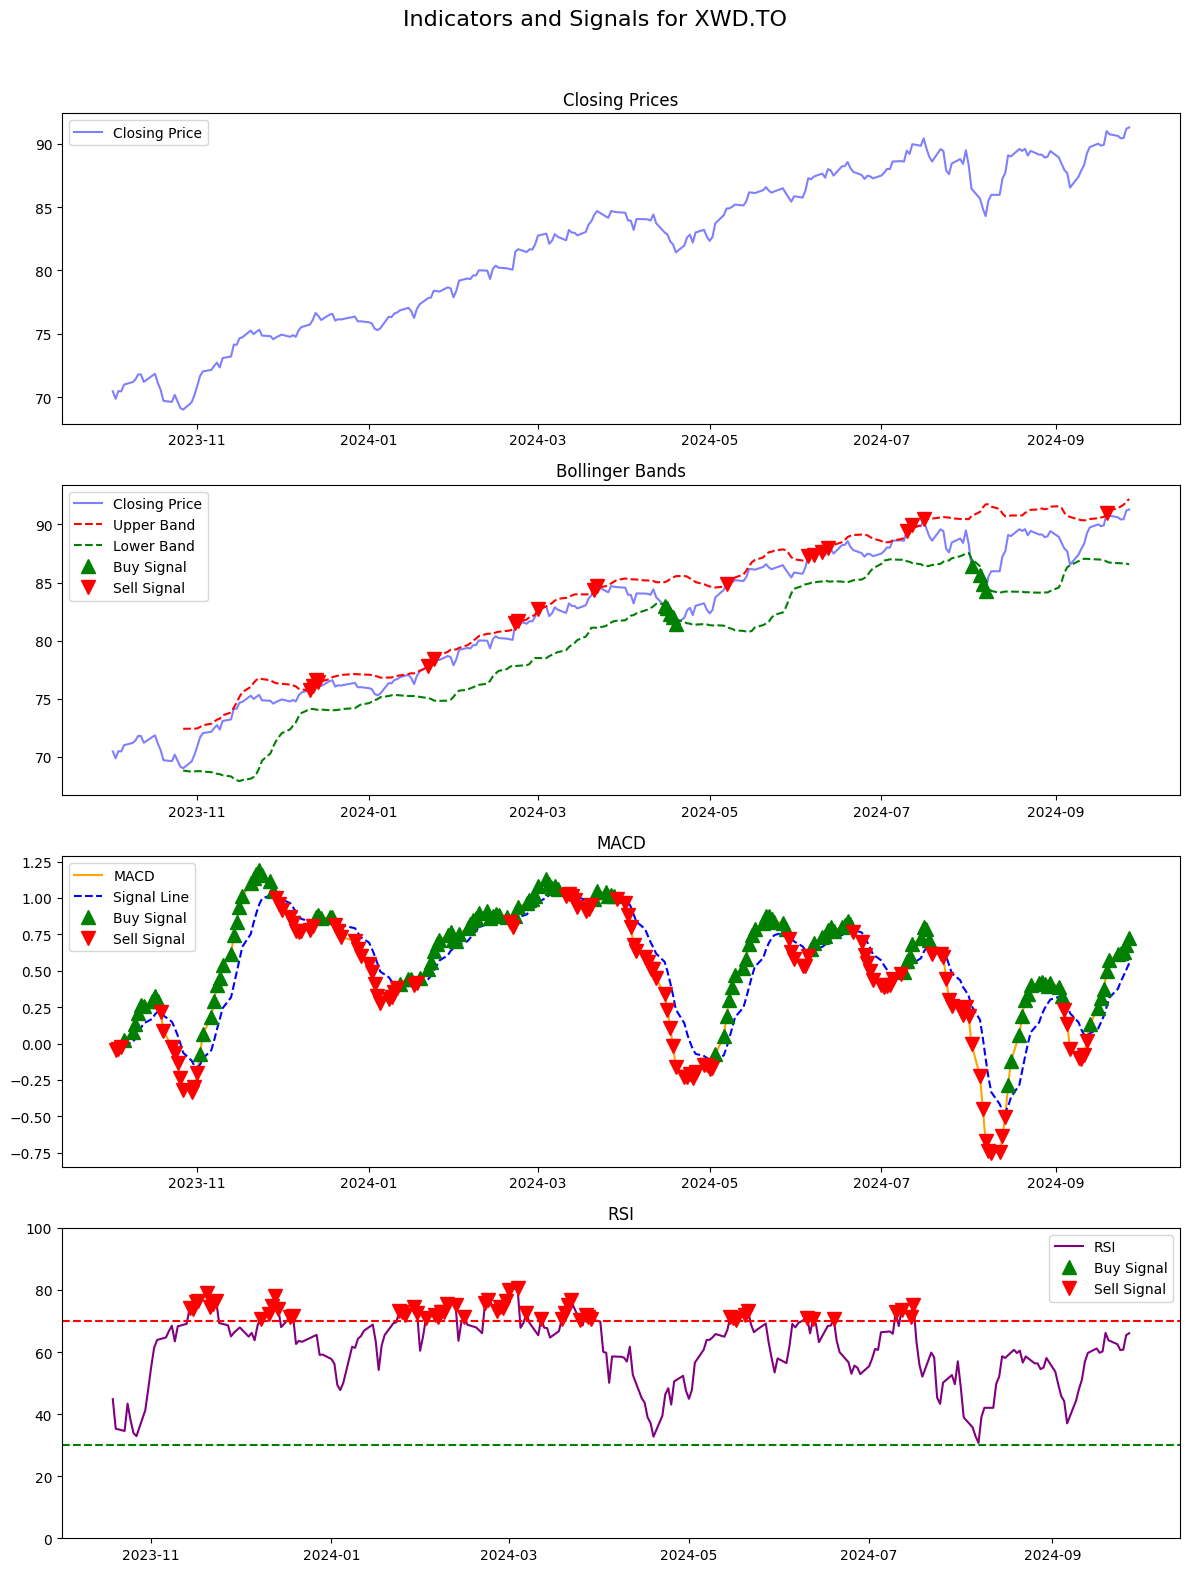

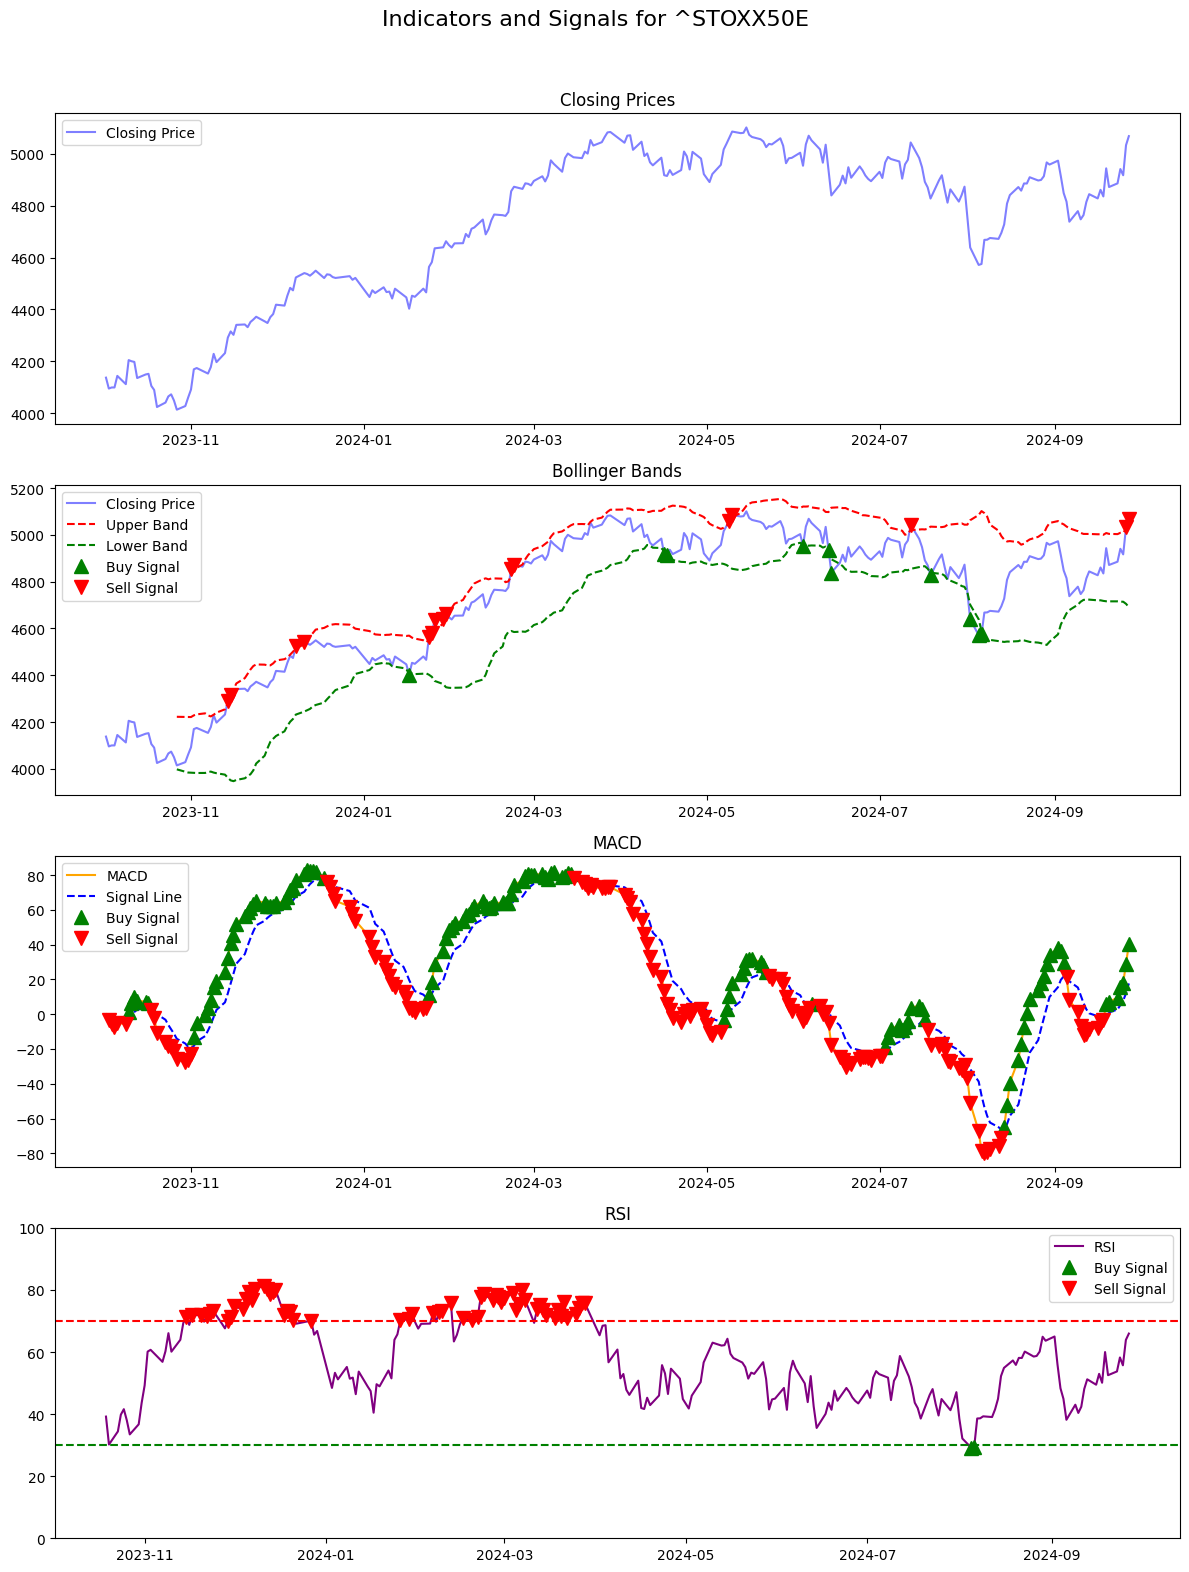

In [15]:
def plot_indicators_and_signals(df, stock_symbol):
    """Plots the closing prices, indicators and buy/sell signals for a given stock."""

    macd, signal, _ = calculate_macd(df['Close'])
    rsi = calculate_rsi(df['Close'])
    sma, upper_band, lower_band = calculate_bollinger_bands(df['Close'])
    signals_macd = macd_signals(df['Close'])
    signals_rsi = rsi_signals(df['Close'])
    signals_bollinger = bollinger_band_signals(df['Close'])

    fig, axs = plt.subplots(4, 1, figsize=(12, 16))  # Increase size for 4 plots
    fig.suptitle(f'Indicators and Signals for {stock_symbol}', fontsize=16)

    # 1. Plot: Closing Prices
    axs[0].plot(df.index, df['Close'], label='Closing Price', color='blue', alpha=0.5)
    axs[0].set_title('Closing Prices')
    axs[0].legend()


    # 1. Plot: Bollinger Bonds
    axs[1].plot(df.index, df['Close'], label='Closing Price', color='blue', alpha=0.5)
    axs[1].plot(df.index, upper_band, label='Upper Band', color='red', linestyle='--')
    axs[1].plot(df.index, lower_band, label='Lower Band', color='green', linestyle='--')
    
    buy_signals = signals_bollinger == 1
    sell_signals = signals_bollinger == -1
    axs[1].plot(df.index[buy_signals], df['Close'][buy_signals], '^', markersize=10, color='green', label='Buy Signal', alpha=1)
    axs[1].plot(df.index[sell_signals], df['Close'][sell_signals], 'v', markersize=10, color='red', label='Sell Signal', alpha=1)
    
    axs[1].set_title('Bollinger Bands')
    axs[1].legend()

    # 2. Plot: MACD
    axs[2].plot(df.index, macd, label='MACD', color='orange')
    axs[2].plot(df.index, signal, label='Signal Line', color='blue', linestyle='--')

    buy_signals_macd = signals_macd == 1
    sell_signals_macd = signals_macd == -1
    axs[2].plot(df.index[buy_signals_macd], macd[buy_signals_macd], '^', markersize=10, color='green', label='Buy Signal', alpha=1)
    axs[2].plot(df.index[sell_signals_macd], macd[sell_signals_macd], 'v', markersize=10, color='red', label='Sell Signal', alpha=1)

    axs[2].set_title('MACD')
    axs[2].legend()

    # 3. Plot: RSI
    axs[3].plot(df.index, rsi, label='RSI', color='purple')
    axs[3].axhline(70, linestyle='--', color='red')
    axs[3].axhline(30, linestyle='--', color='green')  
    
    buy_signals_rsi = signals_rsi == 1
    sell_signals_rsi = signals_rsi == -1
    axs[3].plot(df.index[buy_signals_rsi], rsi[buy_signals_rsi], '^', markersize=10, color='green', label='Buy Signal', alpha=1)
    axs[3].plot(df.index[sell_signals_rsi], rsi[sell_signals_rsi], 'v', markersize=10, color='red', label='Sell Signal', alpha=1)
    axs[3].set_title('RSI')
    axs[3].set_ylim(0, 100)
    axs[3].legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96]) 
    plt.show()


for symbol in new_stock_data.columns:

        stock_df = new_stock_data[[symbol]].dropna()
        stock_df.columns = ['Close']  
        plot_indicators_and_signals(stock_df, symbol)

Prediction